<a href="https://colab.research.google.com/github/rachocr/CCDATSCL_PROJECT/blob/main/FINALS_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import glob
import os
import shutil


sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

print("Importing Libraries Complete.")

Importing Libraries Complete.


## Load, Merge, and Explore Dataset

In [246]:
# 1. Obtain Data with Force Refresh
repo_path = 'CCDATSCL_PROJECT'
if os.path.exists(repo_path):
    shutil.rmtree(repo_path)
    print(f"Refreshing repository to include latest files...")

!git clone https://github.com/rachocr/CCDATSCL_PROJECT.git

# 2. Smart Merge Loop
csv_files = sorted(glob.glob('CCDATSCL_PROJECT/Dataset/Week *.csv'))
week_dfs = []

print("\nLoading and Standardizing Files:")
for file in csv_files:
    file_name = os.path.basename(file)
    df_temp = pd.read_csv(file)

    # CRITICAL FIX: Standardize names BEFORE merging
    # This turns "Sleep Hours (hours)" and "Sleep Hours" BOTH into "Sleep_Hours"
    df_temp.columns = [
        c.split('(')[0].strip().replace(' ', '_')
        for c in df_temp.columns
    ]

    print(f"   -> {file_name} loaded with {len(df_temp.columns)} columns.")
    week_dfs.append(df_temp)

merged_df = pd.concat(week_dfs, ignore_index=True)

# 3. Final Polish
merged_df['Type_of_Coffee'] = merged_df['Type_of_Coffee'].fillna('No Coffee')

print(f"\nAll {len(csv_files)} weeks merged. Total Rows: {len(merged_df)}")

Refreshing repository to include latest files...
Cloning into 'CCDATSCL_PROJECT'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 57 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 271.50 KiB | 6.46 MiB/s, done.
Resolving deltas: 100% (13/13), done.

Loading and Standardizing Files:
   -> Week 1.csv loaded with 13 columns.
   -> Week 2.csv loaded with 13 columns.
   -> Week 3.csv loaded with 13 columns.
   -> Week 4.csv loaded with 13 columns.
   -> Week 5.csv loaded with 13 columns.
   -> Week 6.csv loaded with 13 columns.
   -> Week 7.csv loaded with 13 columns.
   -> Week 8.csv loaded with 13 columns.
   -> Week 9.csv loaded with 13 columns.

All 9 weeks merged. Total Rows: 65


In [247]:
display(merged_df.head())

,Date,Coffee_Intake,Caffeine_Amount,Type_of_Coffee,Brand,Flavor,Sugar_Level,Creamer_Level,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed,Tasks_Note
0,06/12/2025,16,120,Latte,Grill & Grind,Spanish Latte,Medium,Medium,3,4,10,3,"Fix motorcycle, Clean House, Pet Medication"
1,07/12/2025,24,297,Brewed,Dunkin' Donut,Iced Coffee,Medium,Medium,4,3,9,2,"Studying Java, Pet Medication"
2,08/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,6,2,"Fix motorcycle, Pet Medication"
3,09/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,3,2,7,2,"Studying Java, Pet Medication"
4,10/12/2025,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,4,2,9,3,"Studying Java, Pet Medication, Applied Interns..."


In [248]:
display(merged_df.tail())

,Date,Coffee_Intake,Caffeine_Amount,Type_of_Coffee,Brand,Flavor,Sugar_Level,Creamer_Level,Focus_Rating,Productivity_Duration,Sleep_Hours,Tasks_Completed,Tasks_Note
60,04/02/2026,16,120,Latte,Kape at Musika,Spanish Latte,High,High,4,6,7,5,"Fixed Motorcycle, Adjusted my CV/Resume, Made ..."
61,05/02/2026,16,150,Latte,Pickup Coffee,Iced Sea Salt Latte,Medium,Medium,3,5,6,4,"Setup my PC, Checked and Validated the Prototy..."
62,06/02/2026,16,120,Latte,Pickup Coffee,Kasturi,High,High,3,5,7,4,"Meeting with Thesis Group, Dry run for hours, ..."
63,07/02/2026,16,120,Latte,Kape at Musika,Vanilla Latte,Medium,Medium,3,9,8,4,"Studied Regression Models for Thesis, Made not..."
64,08/02/2026,16,120,Latte,Pickup Coffee,Spanish Latte,Medium,Medium,4,3,9,2,Celebritory Favorite Coffee for last week of D...


In [249]:
display(merged_df.isna().sum())

,0
Date,0
Coffee_Intake,0
Caffeine_Amount,0
Type_of_Coffee,0
Brand,6
Flavor,6
Sugar_Level,6
Creamer_Level,6
Focus_Rating,0
Productivity_Duration,0


## Data Cleaning and Preparation

In [250]:
# Manual mappings
sugar_map = {'Low': 12.5, 'Medium': 22.5, 'High': 40.0}
creamer_map = {'Low': 90.0, 'Medium': 135.0, 'High': 185.0}
coffee_type_map = {'Cold Brew': 'Brewed', 'Matcha': 'Latte', 'Americano': 'Espresso', 'Frappuccino': 'Latte'}

# Data Cleaning Pipeline
df_clean = (
    merged_df.assign(
        Date = lambda x: pd.to_datetime(x['Date'], dayfirst=True),

        # Use filter(like=...) to safely find columns even if naming varies (e.g. Sleep_Hours vs Sleep_Hours_hours)
        Sleep_Hours = lambda x: pd.to_numeric(
            x.filter(like='Sleep_Hours').iloc[:, 0], errors='coerce'
        ),

        Coffee_Intake = lambda x: pd.to_numeric(
            x.filter(like='Coffee_Intake').iloc[:, 0], errors='coerce'
        ),

        # FIX: Dynamically find Caffeine column (was Caffeine_Amount or Caffeine_Amount_mg)
        Caffeine_Amount_mg = lambda x: pd.to_numeric(
            x.filter(like='Caffeine_Amount').iloc[:, 0], errors='coerce'
        ),

        Tasks_Completed = lambda x: pd.to_numeric(x['Tasks_Completed'], errors='coerce'),

        Type_of_Coffee = lambda x: x['Type_of_Coffee'].replace(coffee_type_map),
        Est_Sugar_g = lambda x: x['Sugar_Level'].replace(sugar_map),
        Est_Creamer_mL = lambda x: x['Creamer_Level'].replace(creamer_map),

        Caffeine_Level = lambda x: pd.cut(pd.to_numeric(x.filter(like='Caffeine_Amount').iloc[:, 0], errors='coerce'),
                                        bins=[0.1, 100, 200, 1000], labels=['Low', 'Medium', 'High'])
    )
    .drop(columns=['week', 'Tasks_Note'], errors='ignore')
    .dropna(subset=['Tasks_Completed'])
)

print("✅ Data Scrubbed. Verifying Sleep, Intake, and Caffeine columns:")
print(df_clean[['Sleep_Hours', 'Coffee_Intake', 'Caffeine_Amount']].head())

✅ Data Scrubbed. Verifying Sleep, Intake, and Caffeine columns:
   Sleep_Hours  Coffee_Intake  Caffeine_Amount
0           10             16              120
1            9             24              297
2            6             16              120
3            7             16              120
4            9             16              120


/tmp/ipython-input-2994869179.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Est_Sugar_g = lambda x: x['Sugar_Level'].replace(sugar_map),
/tmp/ipython-input-2994869179.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Est_Creamer_mL = lambda x: x['Creamer_Level'].replace(creamer_map),


## Exploratory Data Analysis

In [251]:
# 1. Statistical Summary
print("--- SHAPE & DESCRIPTIVE STATS ---")
# Calculating Skewness and Kurtosis
stats_summary = df_clean[['Caffeine_Amount', 'Tasks_Completed']].agg(['mean', 'std', 'skew', 'kurt']).round(2)
display(stats_summary)


--- SHAPE & DESCRIPTIVE STATS ---


,Caffeine_Amount,Tasks_Completed
mean,130.05,4.60
std,75.10,2.14
skew,0.67,0.39
kurt,0.87,0.15


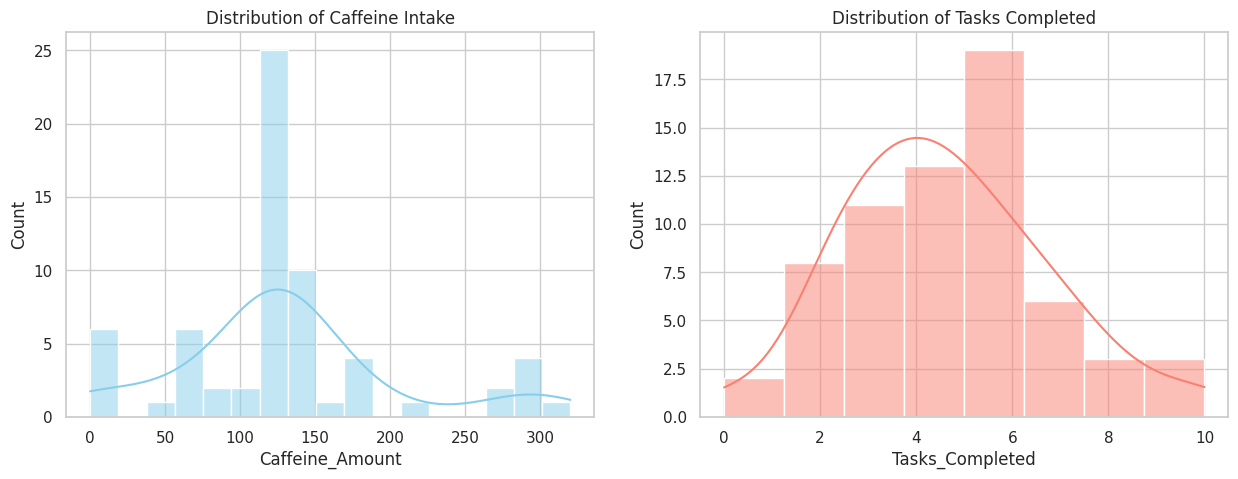

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_clean['Caffeine_Amount'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Caffeine Intake')

sns.histplot(df_clean['Tasks_Completed'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Tasks Completed')

plt.show()

In [253]:
# 2. Aggregation Table (Leaderboard - Excluding 'No Coffee')
leaderboard = (
    df_clean.query("Type_of_Coffee != 'No Coffee'")
    .groupby('Type_of_Coffee')
    .agg(Avg_Tasks=('Tasks_Completed', 'mean'), Count=('Tasks_Completed', 'count'))
    .sort_values('Avg_Tasks', ascending=False)
)
print("\n📊 TABLE: Productivity Leaderboard")
display(leaderboard)


📊 TABLE: Productivity Leaderboard


,Avg_Tasks,Count
Type_of_Coffee,,
Espresso,6.200000,5
Instant,5.375000,8
Brewed,4.857143,14
Latte,4.625000,32



[Outlier Check] Tasks_Completed: Found 0 anomalies.


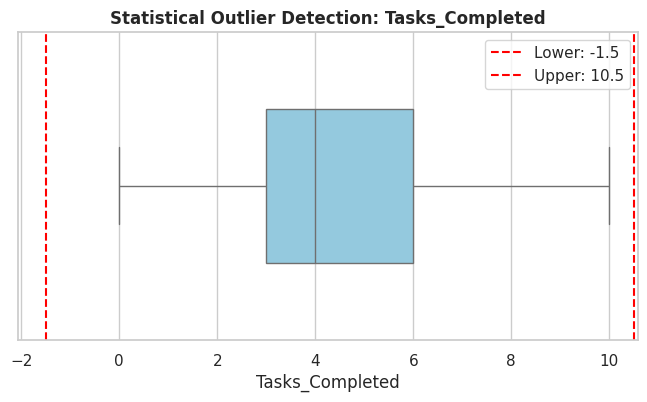

In [254]:
# 3. Outlier Detection

def check_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = data.query(f"{col} < @lower or {col} > @upper")
    print(f"\n[Outlier Check] {col}: Found {len(outliers)} anomalies.")

    # 2. Visual Representation
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col], color='skyblue', width=0.5)

    # Add vertical lines for the statistical bounds
    plt.axvline(lower, color='red', linestyle='--', label=f'Lower: {lower:.1f}')
    plt.axvline(upper, color='red', linestyle='--', label=f'Upper: {upper:.1f}')

    plt.title(f'Statistical Outlier Detection: {col}', fontweight='bold')
    plt.legend()
    plt.show()

    # 3. Table of Anomalies
    if not outliers.empty:
        display(outliers[['Date', col, 'Type_of_Coffee', 'Caffeine_Level']])

check_outliers(df_clean, 'Tasks_Completed')

/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


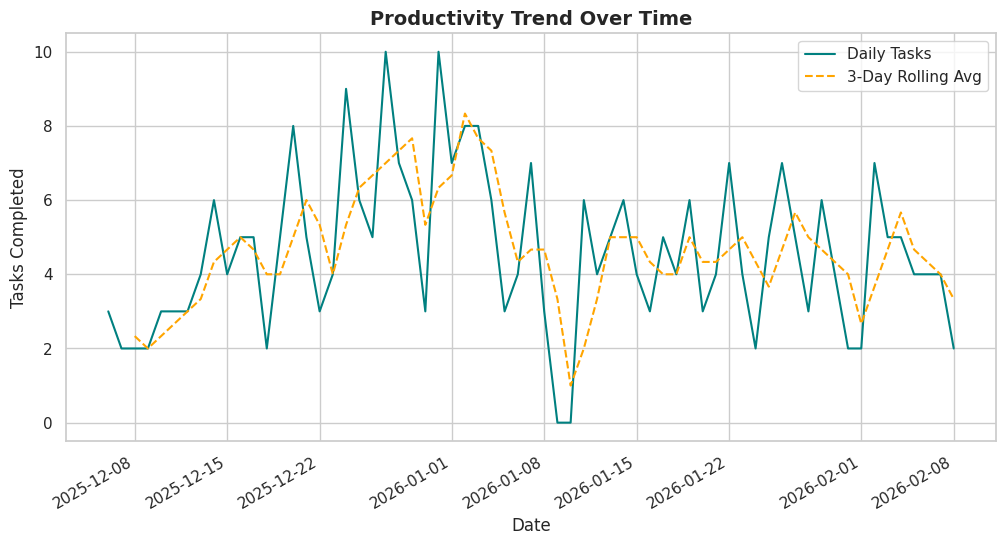

In [255]:
# 4. Time Series Analytics

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_clean, x='Date', y='Tasks_Completed', color='teal', label='Daily Tasks')

# Rolling average helps determine if there is a general burnout or improvement trend
df_clean.set_index('Date')['Tasks_Completed'].rolling(3).mean().plot(color='orange', ls='--', label='3-Day Rolling Avg')

plt.title('Productivity Trend Over Time', fontsize=14, fontweight='bold')
plt.ylabel('Tasks Completed')
plt.legend()
plt.show()

/tmp/ipython-input-4013305533.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean.dropna(subset=['Caffeine_Level']), x='Caffeine_Level', y='Tasks_Completed', palette="Blues")


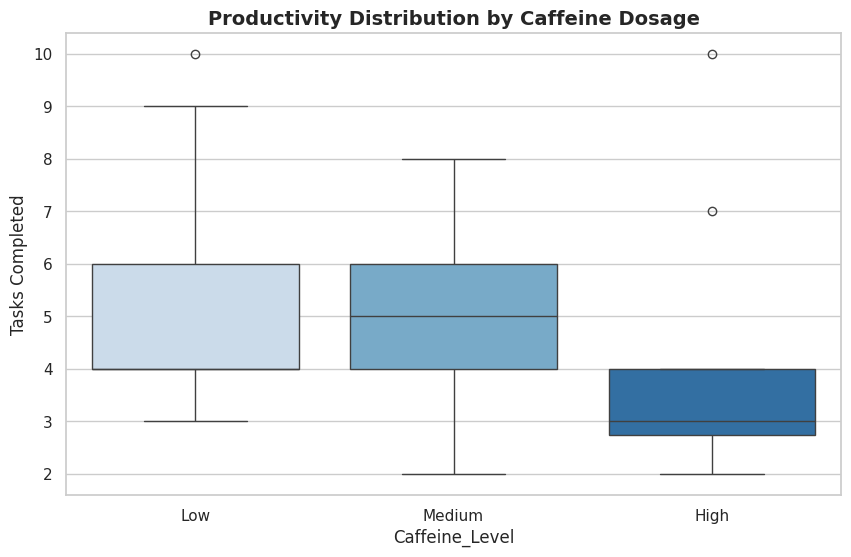

In [256]:
# 5. Dosage Effect

plt.figure(figsize=(10, 6))
# Dropping NaNs in Caffeine_Level to hide the "0mg" days for a cleaner dosage comparison
sns.boxplot(data=df_clean.dropna(subset=['Caffeine_Level']), x='Caffeine_Level', y='Tasks_Completed', palette="Blues")

plt.title('Productivity Distribution by Caffeine Dosage', fontsize=14, fontweight='bold')
plt.ylabel('Tasks Completed')
plt.show()

/tmp/ipython-input-612762205.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_clean.dropna(subset=['Est_Sugar_g']).pivot_table(index='Caffeine_Level', columns='Sugar_Level', values='Tasks_Completed')


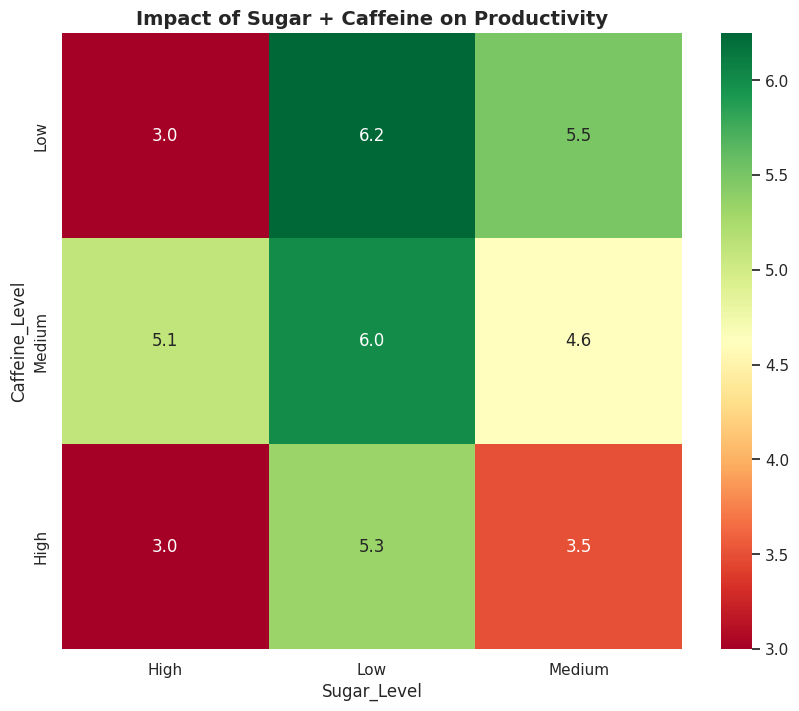

In [257]:
# 6. Caffeine vs Sugar

plt.figure(figsize=(10, 8))
# Visualizing the multivariate relationship between dosage, sugar, and output
pivot = df_clean.dropna(subset=['Est_Sugar_g']).pivot_table(index='Caffeine_Level', columns='Sugar_Level', values='Tasks_Completed')
sns.heatmap(pivot, annot=True, cmap='RdYlGn', fmt=".1f")

plt.title('Impact of Sugar + Caffeine on Productivity', fontsize=14, fontweight='bold')
plt.show()

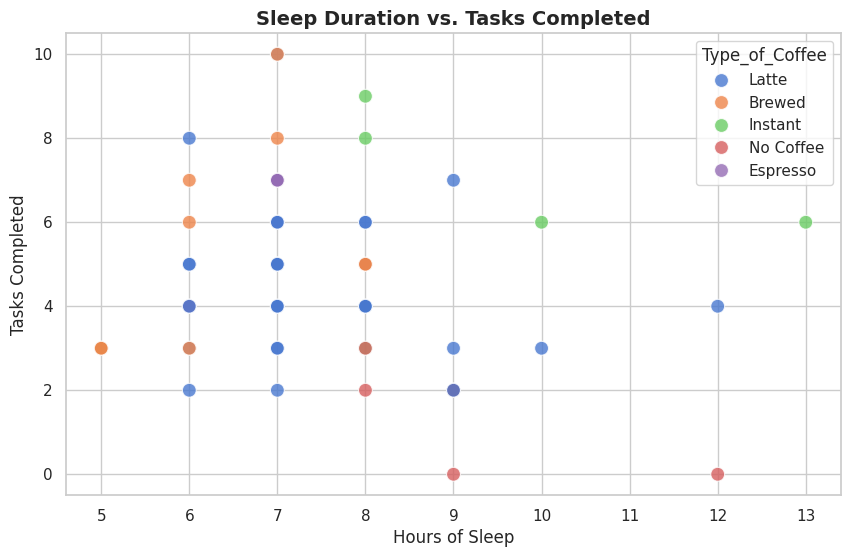

In [258]:
# 7. Sleep duration vs Tasks

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Sleep_Hours', y='Tasks_Completed', hue='Type_of_Coffee', s=100, alpha=0.8)

plt.title('Sleep Duration vs. Tasks Completed', fontsize=14, fontweight='bold')
plt.xlabel('Hours of Sleep')
plt.ylabel('Tasks Completed')
plt.show()

## Statistical Tests


In [259]:
alpha = 0.05

print("--- TEST 1: PEARSON CORRELATION (Caffeine vs. Productivity) ---")
print("H01 (Null): Caffeine Amount has no significant linear effect on productivity.")
print("H11 (Alt): Caffeine Amount has significant effect on productivity.\n")

corr, p_corr = stats.pearsonr(df_clean['Caffeine_Amount_mg'], df_clean['Tasks_Completed'])
print(f"r: {corr:.4f} | P-value: {p_corr:.4f}")

if p_corr < alpha:
    print(f"DECISION: Reject H01. Significant linear correlation detected.")
else:
    print(f"DECISION: Fail to Reject H01. A linear relationship was not detected.")

--- TEST 1: PEARSON CORRELATION (Caffeine vs. Productivity) ---
H01 (Null): Caffeine Amount has no significant linear effect on productivity.
H11 (Alt): Caffeine Amount has significant effect on productivity.

r: 0.1111 | P-value: 0.3781
DECISION: Fail to Reject H01. A linear relationship was not detected.


In [260]:
print("--- TEST 2: ONE-WAY ANOVA (Coffee Type vs. Productivity) ---")
print("H02 (Null): There is no significant difference in productivity based on coffee type.")
print("H12 (Alt): There is a significant difference in productivity based on coffee type.\n")

groups = [df_clean.query(f"Type_of_Coffee == '{t}'")['Tasks_Completed'] for t in df_clean['Type_of_Coffee'].unique()]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"F-Statistic: {f_stat:.4f} | P-value: {p_anova:.4f}")
if p_anova < alpha:
    print(f"DECISION: Reject H02. Significant evidence that coffee type influences productivity.")
else:
    print(f"DECISION: Fail to Reject H02.")

print("\n" + "="*80 + "\n")



--- TEST 2: ONE-WAY ANOVA (Coffee Type vs. Productivity) ---
H02 (Null): There is no significant difference in productivity based on coffee type.
H12 (Alt): There is a significant difference in productivity based on coffee type.

F-Statistic: 5.2586 | P-value: 0.0011
DECISION: Reject H02. Significant evidence that coffee type influences productivity.




## Modeling

                            OLS Regression Results                            
Dep. Variable:        Tasks_Completed   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     7.852
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           0.000913
Time:                        16:26:28   Log-Likelihood:                -133.90
No. Observations:                  65   AIC:                             273.8
Df Residuals:                      62   BIC:                             280.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2401      0.702      3.192      0.0

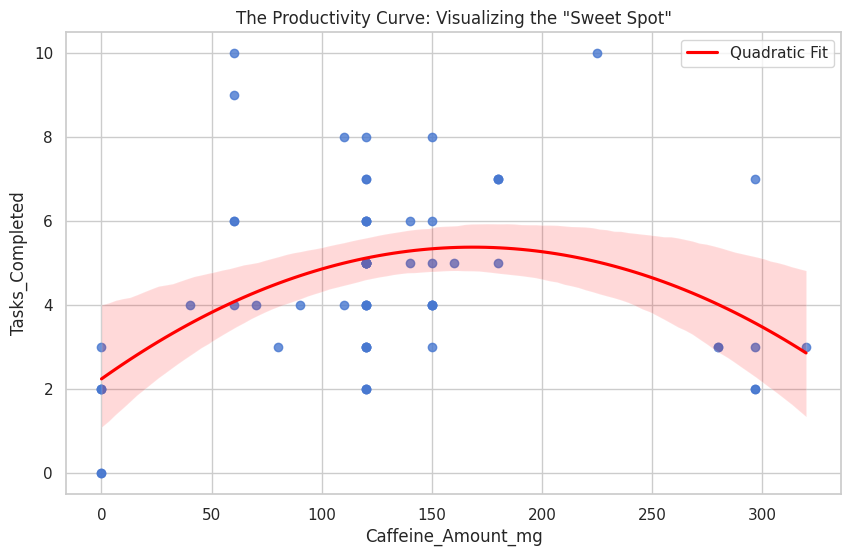

In [261]:
X = df_clean['Caffeine_Amount_mg']
y = df_clean['Tasks_Completed']
X_poly = sm.add_constant(pd.DataFrame({'Caff': X, 'Caff_Sq': X**2}))

model = sm.OLS(y, X_poly).fit()
print(model.summary())

# Plotting the Fit
plt.figure(figsize=(10, 6))
sns.regplot(x='Caffeine_Amount_mg', y='Tasks_Completed', data=df_clean, order=2,
            line_kws={'color':'red', 'label':'Quadratic Fit'})
plt.title('The Productivity Curve: Visualizing the "Sweet Spot"')
plt.legend()
plt.show()